# todo
- translated .asc crs changes?
- change gdal dependency to qGIS
- plot (2y3d) jupyterlab interactive

# install

```bash
sudo apt install python3-gdal gdal-bin
git clone
cd
python3 -m venv pyvenv
source pyvenv/bin/activate
eio selfcheck
```

# usage
## elevation to tif
clip the SRTM1 30m DEM

In [1]:
import elevation
# bounds 'left bottom right top' order.
# latitude and longitude coordinates (more precisely in geodetic coordinates in the WGS84 reference system EPSG:4326)
#bounds = (-70.64499, -33.44232, -70.64213, -33.43770) # sta lucia
#bounds = (-70.6543,-33.4444, -70.5698, -33.3793) # parque metropolitano
#bounds = (-71.5731237178895, -33.0493175478135, -71.5287880407362, -33.0258435387726) # incendion vina del mar
bounds = (-70.6517350942473, -33.4341245538389, -70.6084247534509, -33.4112941796125)


# else output goes to elevation.CACHE_DIR e.g.: ~/.cache/elevation/SRTM1/out.tif
import os
output = os.path.join( os.getcwd() , 'dem_30m.tif')
elevation.clip( bounds, product='SRTM1', output=output)

make: Entering directory '/home/fdo/.cache/elevation/SRTM1'
make: Nothing to be done for 'download'.
make: Leaving directory '/home/fdo/.cache/elevation/SRTM1'
make: Entering directory '/home/fdo/.cache/elevation/SRTM1'
make: Nothing to be done for 'all'.
make: Leaving directory '/home/fdo/.cache/elevation/SRTM1'
make: Entering directory '/home/fdo/.cache/elevation/SRTM1'
cp SRTM1.vrt SRTM1.ac9724599ed44dcd8dd6c6d8178ff2bb.vrt
make: Leaving directory '/home/fdo/.cache/elevation/SRTM1'
make: Entering directory '/home/fdo/.cache/elevation/SRTM1'
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin -70.6517350942473 -33.4112941796125 -70.6084247534509 -33.4341245538389 SRTM1.ac9724599ed44dcd8dd6c6d8178ff2bb.vrt /home/fdo/source/fire2gui/elevation/dem_30m.tif
rm -f SRTM1.ac9724599ed44dcd8dd6c6d8178ff2bb.vrt
make: Leaving directory '/home/fdo/.cache/elevation/SRTM1'


## tif to raster(io) manipulations

In [2]:
import rasterio
dataset = rasterio.open('dem_30m.tif')

# some properties
print(dataset.dtypes, dataset.width, dataset.height, dataset.res, dataset.bounds, dataset.crs)

# upper left corner
dataset.transform * (0, 0) 
# lower right corner
dataset.transform * (dataset.width, dataset.height)

# get data array
dataset.indexes
band1 = dataset.read(1) # returns 2d numpy array

('int16',) 156 82 (0.0002777777777777778, 0.0002777777777777778) BoundingBox(left=-70.65180555555555, bottom=-33.43402777777777, right=-70.60847222222222, top=-33.411249999999995) EPSG:4326


In [3]:
# print info
!rio info dem_30m.tif --indent 2 --verbose

{
  "blockxsize": 256,
  "blockysize": 256,
  "bounds": [
    -70.65180555555555,
    -33.43402777777777,
    -70.60847222222222,
    -33.411249999999995
  ],
  "checksum": [
    21260
  ],
  "colorinterp": [
    "gray"
  ],
  "compress": "deflate",
  "count": 1,
  "crs": "EPSG:4326",
  "descriptions": [
    null
  ],
  "driver": "GTiff",
  "dtype": "int16",
  "height": 82,
  "indexes": [
    1
  ],
  "interleave": "band",
  "lnglat": [
    -70.6301388888889,
    -33.42263888888888
  ],
  "mask_flags": [
    [
      "nodata"
    ]
  ],
  "nodata": -32768.0,
  "res": [
    0.0002777777777777778,
    0.0002777777777777778
  ],
  "shape": [
    82,
    156
  ],
  "stats": [
    {
      "max": 889.0,
      "mean": 618.6495465916178,
      "min": 534.0,
      "std": 67.31603374229468
    }
  ],
  "tiled": true,
  "transform": [
    0.0002777777777777778,
    0.0,
    -70.65180555555555,
    0.0,
    -0.0002777777777777778,
    -33.411249999999995,
    0.0,
    0.0,
    1.0
  ],
  "units": [

In [4]:
# get json info
import json
info = json.loads(os.popen('rio info dem_30m.tif').read())

## plot

In [5]:
from matplotlib import pyplot as plt
def plot( dataset):
    plt.clf()
    plt.imshow(dataset.read(1), cmap='terrain')
    plt.savefig('out.png')
    plt.show()

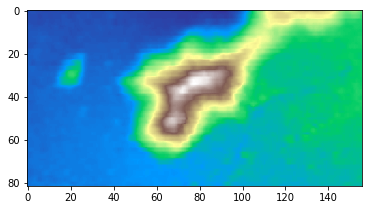

In [6]:
plot(dataset)

## translate dem
NOTE: "!" means command is run in the terminal  
### tif -> asc

In [7]:
! gdal_translate -of AAIGrid dem_30m.tif dem_30m.asc

Input file size is 156, 82
0...10...20...30...40...50...60...70...80...90...100 - done.


### tif -> asc /3 cellsize
As SRTM1 data source is 30m but fire2cell uses 100m do:

In [8]:
dataset.res[0]*10/3

0.000925925925925926

In [9]:
!gdal_translate -tr 0.000925925925925926 0.000925925925925926 -of AAIGrid dem_30m.tif dem_100m.tif

Input file size is 156, 82
0...10...20...30...40...50...60...70...80...90...100 - done.


#### plot

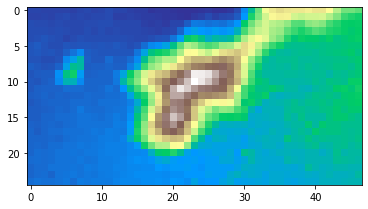

In [10]:
dataset = rasterio.open('dem_100m.tif')
plot(dataset)

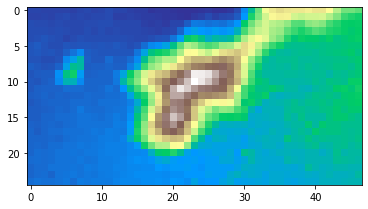

In [11]:
dataset = rasterio.open('dem_100m.asc')
plot(dataset)

## lat/long <-> (chile) utm
### gdal

### qgis

In [12]:
from qgis.core import (
        QgsCoordinateReferenceSystem,
        QgsCoordinateTransform,
        QgsProject,
        QgsPointXY,
        )

In [13]:
crsSrc = QgsCoordinateReferenceSystem("EPSG:24879")
crsDest = QgsCoordinateReferenceSystem("EPSG:4326")
transformContext = QgsProject.instance().transformContext()
xform = QgsCoordinateTransform(crsSrc, crsDest, transformContext)

In [14]:
point24879 = QgsPointXY(7864180.88813121151179075, -3954168.27993376972153783)
point4326 = xform.transform(point24879)
point4326

<QgsPointXY: POINT(43.19725545081938378 -27.76883310127086091)>

In [15]:
point4326 = QgsPointXY(-70.645138888889, -33.442361111111)
point24879 = xform.transform(point4326, QgsCoordinateTransform.ReverseTransform)
point24879

<QgsPointXY: POINT(347282.24207610113080591 6298780.79974185116589069)>

### HINT
- Desde, lat/long es: WGS84 reference system EPSG:4326
- Hasta, en Chile:
 - zona sur: EPSG:24879 > PSAD56 / UTM zone 19S
 - zona norte: EPSG:29193 SAD69 / UTM zone 23S

# references
https://www.sirgaschile.cl/ConversionSC/transformadorDatum.html  
https://epsg.io/24879  
https://epsg.io/29193  
https://gdal.org/programs/gdaltransform.html  
https://gdal.org/programs/gdal_translate.html  
https://www.researchgate.net/post/How-to-obtain-digital-elevation-data-in-ascii-format  
https://www.openstreetmap.org  
http://elevation.bopen.eu/en/stable/quickstart.html  
https://rasterio.readthedocs.io/en/latest/quickstart.html  

# plop
https://stackoverflow.com/questions/55827778/elevation-xyz-data-to-slope-gradient-map-using-python  
https://stackoverflow.com/search?q=python+elevation&s=676696f8-8555-45f8-b4ae-c2adceb79ded  